# Project FILIÈRE RECHERCHE

Under the supervision of :

Elisabeth Lahalle

Students :

- Ricardo Chiquetto do Lago
- Maxsuel Fernandes de Almeida
- Samara Ndiaye
- Ana Cecilia Reghini
- Lucas Tramonte

# Libraries

In [152]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import scipy.stats as st
import statsmodels.api as sm
from scipy.stats import norm
from scipy.ndimage import binary_dilation, binary_closing
from more_itertools import consecutive_groups

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM ,Dropout , Dense 

# Data

In [153]:
data_gamma_irradiation = pd.read_csv("Assets/Data/2015_months_DebitDoseA.csv")
data_hygometry = pd.read_csv("Assets/Data/2015_months_HYGR.csv")
data_patm = pd.read_csv("Assets/Data//2015_months_PATM.csv")
data_temp = pd.read_csv("Assets//Data//2015_months_TEMP.csv")

In [154]:
data = data_gamma_irradiation.copy()
data

,24/02/2015 11:20,30/04/2015 13:10,22/06/2015 07:31,20/10/2015 09:18
0,92.8536,96.38690,96.98370,104.8191
1,91.8084,95.68260,96.33440,103.6979
2,93.3221,97.17039,96.67419,104.6446
3,91.7464,97.41650,97.40680,104.3136
4,93.4146,97.39280,97.60400,104.5342
...,...,...,...,...
40314,103.1037,97.12400,101.08090,97.3781
40315,102.4074,98.34760,100.19280,98.0843
40316,103.0529,98.91140,101.56070,99.6903
40317,102.9746,98.82339,101.22470,100.9240


# Data Visualization

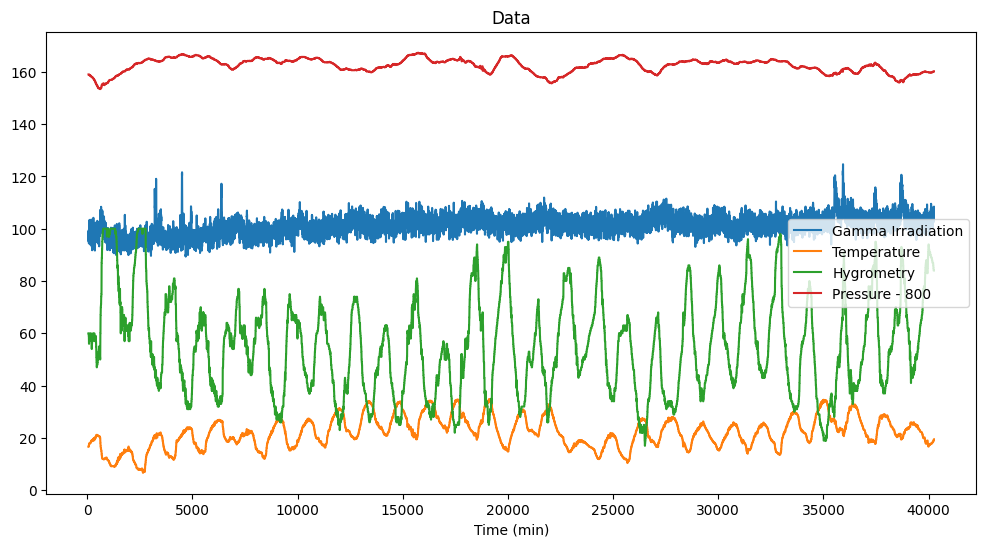

In [155]:
# Define the month (1: February, 2: April, 3: June, 4: October)
month = 3  # selected month: June

# Extract data for the selected month
sigg = data.iloc[:, month-1]  # Gamma irradiation data
sigt = data_temp.iloc[:, month-1]               # Temperature data
sigh = data_hygometry.iloc[:, month-1]          # Hygrometry data
sigp = data_patm.iloc[:, month-1]               # Atmospheric pressure data

# Remove the first and last hour of data
N = len(sigg)  # number of data points
fe = 1/60      # sampling frequency
t = list(range(N))  # time vector

Nh = 60  # 1 hour
t_trimmed = t[Nh:N-Nh]

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(t_trimmed, sigg[Nh:N-Nh], label='Gamma Irradiation')
plt.plot(t_trimmed, sigt[Nh:N-Nh], label='Temperature')
plt.plot(t_trimmed, sigh[Nh:N-Nh], label='Hygrometry')
plt.plot(t_trimmed, sigp[Nh:N-Nh] - 800, label='Pressure - 800')

plt.xlabel('Time (min)')
plt.title('Data')
plt.legend()
plt.show()


### IQR for outlier detection 

In [ ]:
def IQR(X_train, month_col, month_name):
    """
    Function to process the data for a specific month, detect anomalies, and plot the results.
    
    Parameters:
    - X_train: DataFrame containing training data for all columns
    - month_col: index or name of the column representing the specific month to be processed
    - month_name: name of the month (for plot title)
    """
    # Extract data for the selected month
    sigg = X_train.iloc[:, month_col]

    # Remove the first and last hour of data
    N = len(sigg)  # number of data points
    Nh = 60  # 1 hour (60 minutes)
    t = list(range(N))  # time vector
    t_trimmed = t[Nh:N-Nh]  # trimming first and last hour

    ## Anomaly: IQR
    Q1 = sigg.quantile(0.25)
    Q3 = sigg.quantile(0.75)
    IQR = Q3 - Q1

    threshold_lower = Q1 - 2 * IQR
    threshold_upper = Q3 + 2 * IQR

    # Detect anomalies
    anomalies = X_train[(X_train < threshold_lower) | (X_train > threshold_upper)]
    sigg_anomaly = anomalies.iloc[:, month_col]

    # Remove the first and last hour of anomaly data
    N_a = len(sigg_anomaly)  # number of data points
    t_a = list(range(N_a))  # time vector for anomalies
    t_trimmed_a = t_a[Nh:N_a-Nh]

    plt.figure(figsize=(12, 6))
    plt.plot(t_trimmed, sigg[Nh:N-Nh], label=f'Gamma Irradiation - {month_name}')
    plt.plot(t_trimmed_a, sigg_anomaly[Nh:N_a-Nh], label=f'Gamma Irradiation anomalies - {month_name}', color='r')

    plt.xlabel('Time (min)')
    plt.title(f'Data - {month_name}')
    plt.legend()
    plt.show()

# Split the data into training and testing sets
X_train = data.iloc[:, 0:3]
# Remove rows where any value in the row exceeds 200
X_train = X_train.loc[(X_train <= 160).all(axis=1)]
X_test = data.iloc[:, -1]

IQR(X_train, 0, "February") 
IQR(X_train, 1, "April")    
IQR(X_train, 2, "June")     


### SDT method to detect collectif motifs

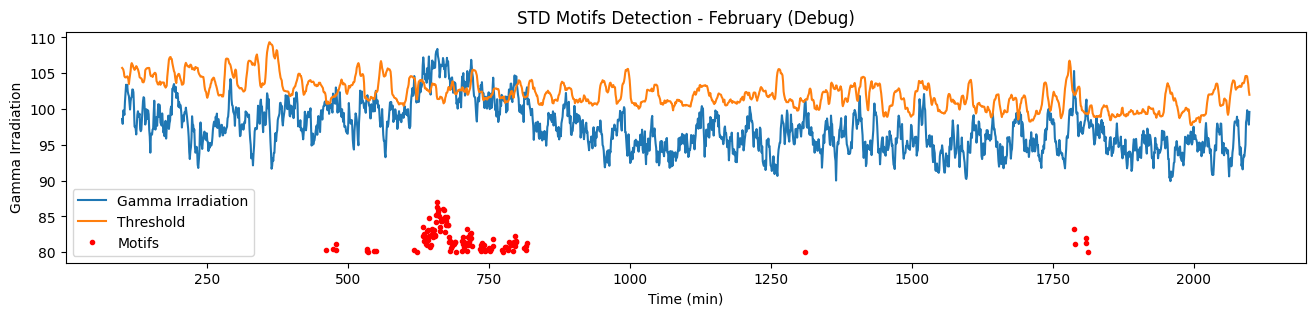

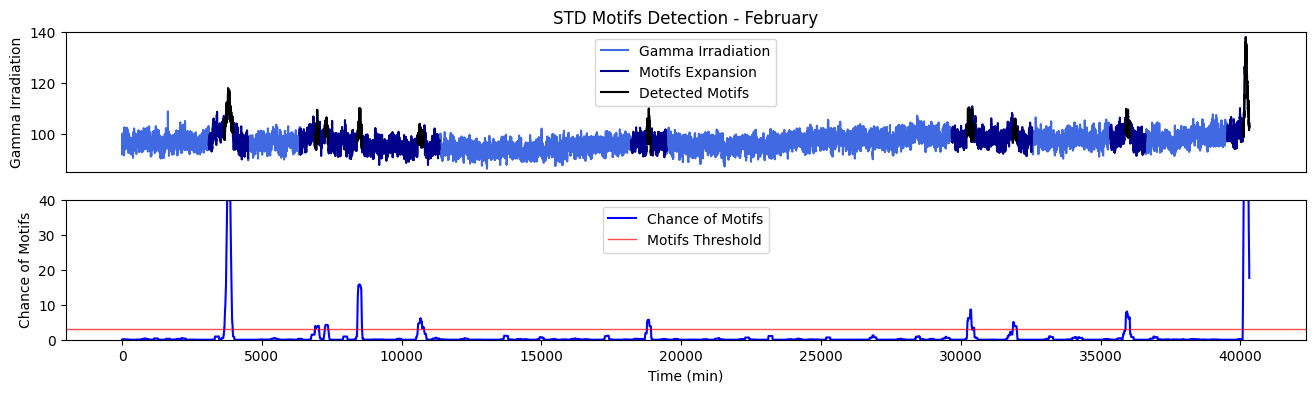

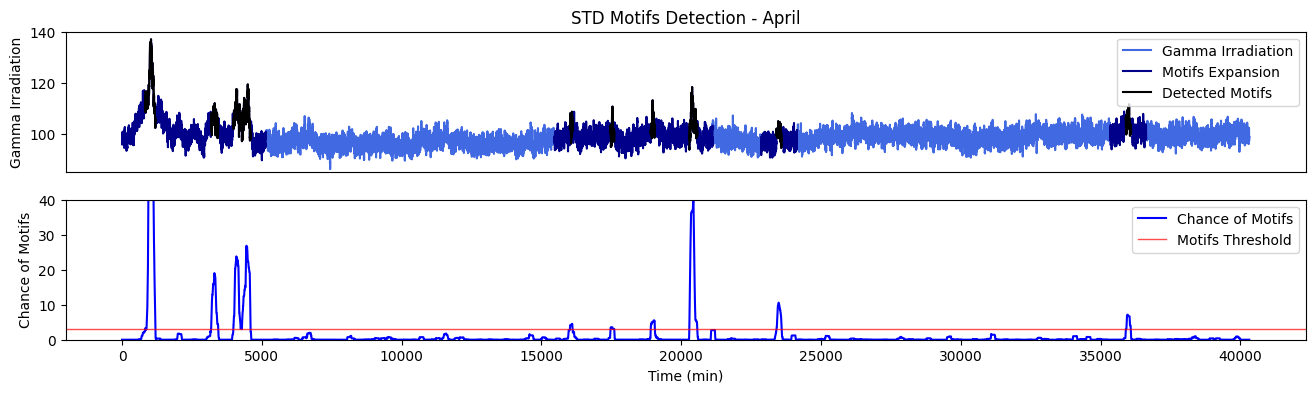

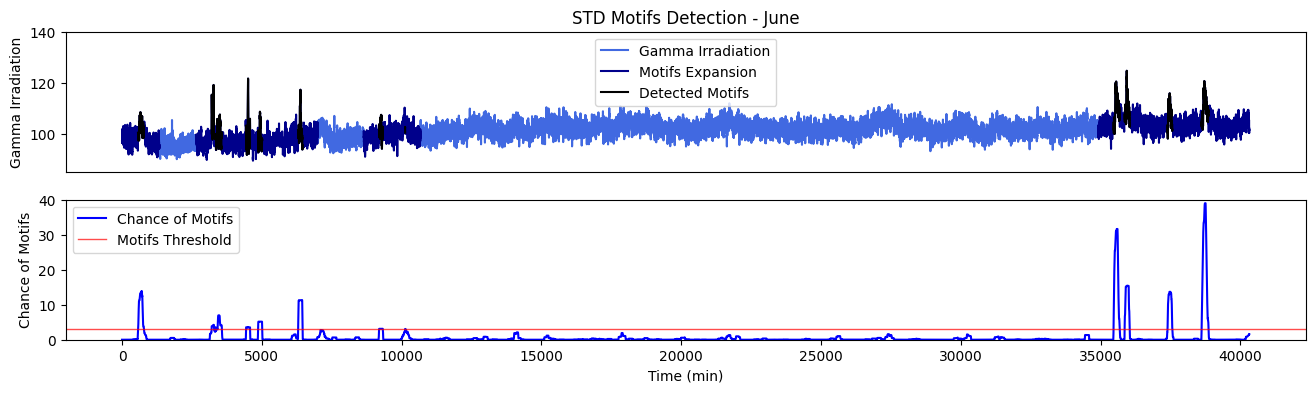

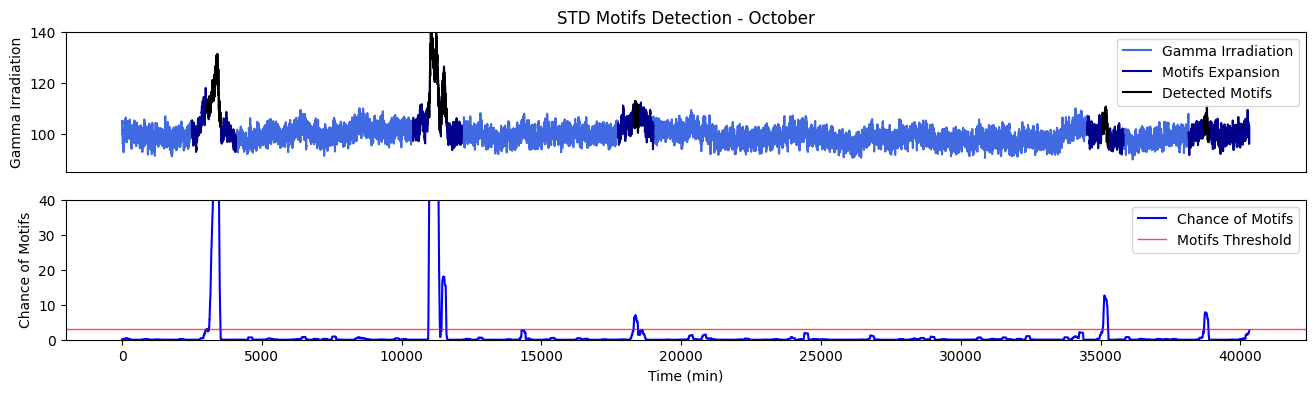

In [156]:
# Function to compute the moving mean
def compute_moving_mean(signal, window_size):
    return signal.rolling(window=window_size, min_periods=1, center=True).mean()

# Function to compute the moving standard deviation
def compute_moving_std(signal, window_size):
    return signal.rolling(window=window_size, min_periods=1, center=True).std()

# Defining the structuring element for binary dilation
structure = np.ones(5)  # Window size 5

# Function to remove outliers, replacing values above the threshold with the mean
def remove_outliers(s, threshold=800):
    s = s.copy()
    idx = s > threshold
    expanded_series = binary_dilation(idx, structure=structure)
    mu = s.mean()
    s[expanded_series] = mu
    return s

# Apply outlier removal to the first month of gamma irradiation data
filtered_data = data_gamma_irradiation.copy()
filtered_data.iloc[:, 0] = remove_outliers(data_gamma_irradiation.iloc[:, 0])

# Select the signal and time
signal = filtered_data.iloc[:, :]  
time = t  

# Window parameters
lw = 20  # Window length for moving standard deviation
n = 70   # Multiplier for the moving mean window

# Step 1: Compute the moving mean with window size n*lw
moving_mean = compute_moving_mean(signal, window_size=n*lw)

# Step 2: Compute the moving standard deviation with window size lw
moving_std = compute_moving_std(signal, window_size=lw)

# Step 3: Compute the threshold as moving_mean + 3 * moving_std
threshold = moving_mean + 3 * moving_std

# Step 4: Identify points in the signal that exceed the threshold
dif = signal - threshold
dif[dif < 0] = 0

# Step 5: Motif detection
coef = 10  # Multiplicative factor for visualization
dif_mean = compute_moving_mean(dif, 150) * coef  # Moving mean of dif
th = 0.3 * coef  # Threshold for motif detection
detection = dif_mean > th  # Motif detection

# Step 6: Dilation of the detected motifs
dilatation_window = np.ones(shape=(1100, 1))  
expanded_window = np.ones(shape=(1000, 1))  
expanded_detection = binary_dilation(detection, structure=dilatation_window)
closed_detection = binary_closing(expanded_detection, structure=expanded_window, border_value=True)

# Step 7: Motif extraction
motifs = signal[expanded_detection]
plotable_dif = dif[dif > 0]

# Plot the data (Zoom In for February)
plt.figure(figsize=(16, 3))
plt.plot(time[100:2100], signal.iloc[100:2100, month-1], label='Gamma Irradiation')
plt.plot(time[100:2100], threshold.iloc[100:2100, month-1], label='Threshold')
plt.plot(80 + plotable_dif.iloc[100:2100, month-1], 'o', label='Motifs', color='red', markersize=3)
plt.xlabel('Time (min)')
plt.ylabel('Gamma Irradiation')
plt.title(f'STD Motifs Detection - February (Debug)')
plt.legend()

# Zoom out plot (analysis for different months)
months = ['February', 'April', 'June', 'October']  # Define the months
for i in range(4):
    plt.figure(figsize=(16, 4))

    plt.subplot(2, 1, 1)
    plt.title(f'STD Motifs Detection - {months[i]}')
    plt.plot(time, signal.mask(closed_detection).iloc[:, i], label='Gamma Irradiation', color="royalblue")
    plt.plot(time, signal.mask(~closed_detection).iloc[:, i], label='Motifs Expansion', color="darkblue")
    plt.plot(time, signal[detection].iloc[:, i], label='Detected Motifs', color="black")
    plt.ylim(85, 140)
    plt.xticks([])
    plt.ylabel('Gamma Irradiation')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(time, dif_mean.iloc[:, i], label='Chance of Motifs', color="blue")
    plt.axhline(y=th, color='red', label='Motifs Threshold', linestyle='-', linewidth=1, alpha=0.7)
    plt.ylim(0, 40)
    plt.xlabel('Time (min)')
    plt.ylabel('Chance of Motifs')
    plt.legend()

plt.show()

In [157]:
def false_sequence_extractor(signal, boolean_mask):
    # Find the indices where the value changes
    change_points = np.asarray(np.diff(boolean_mask.astype(int)) != 0).nonzero()[0] + 1
    
    # Add start and end points for completeness
    change_points = np.concatenate(([0], change_points, [len(boolean_mask)]))
    
    # Extract sequences of False values
    false_sequences = []
    for i in range(len(change_points) - 1):
        start, end = change_points[i], change_points[i + 1]
        if not boolean_mask[start]:
            false_sequences.append(signal[start:end])
    
    return false_sequences

normal_signals_df = pd.DataFrame(index=range(24237)) # 24237 is the length of the longest sequence
num = 0

# Dictionary to hold the total count of data points for each month
month_data_count = {1: 0, 2: 0, 3: 0, 4: 0}
months = ['February', 'April', 'June', 'October']

# Extract sequences of normal (False) values and calculate total lengths for each month
for i in range(4):
    normal_sequences = false_sequence_extractor(signal.iloc[:, i], closed_detection[:, i])
    for j, sequence in enumerate(normal_sequences):
        sequence.reset_index(drop=True, inplace=True)
        normal_signals_df[f'Normal {num}'] = sequence
        month_data_count[i + 1] += len(sequence)  # Add the length of the sequence to the corresponding month
        num += 1
        
for i in range(4):
    print(f'Total data points for {months[i]}: {month_data_count[i + 1]}')
    
#save the normal sequences
normal_signals_df.to_json('Assets/Data/normal_sequences_df.json')

Total data points for February: 27752
Total data points for April: 26951
Total data points for June: 27191
Total data points for October: 32285


Normal 1 is from month 1 and has length 3105

Normal 2 is from month 1 and has length 1846

Normal 3 is from month 1 and has length 6869

Normal 4 is from month 1 and has length 10209

Normal 5 is from month 1 and has length 2790

Normal 6 is from month 1 and has length 2933

Normal 7 is from month 2 and has length 10323

Normal 8 is from month 2 and has length 1733

Normal 9 is from month 2 and has length 11208

Normal 10 is from month 2 and has length 3687

Normal 11 is from month 3 and has length 1316

Normal 12 is from month 3 and has length 1638

Normal 13 is from month 3 and has length 24237

Normal 14 is from month 4 and has length 2500

Normal 15 is from month 4 and has length 6338

Normal 16 is from month 4 and has length 5596

Normal 17 is from month 4 and has length 15517

Normal 18 is from month 4 and has length 2334


In [158]:
df = pd.read_json('Assets/Data/normal_sequences_df.json')
df

,Normal 0,Normal 1,Normal 2,Normal 3,Normal 4,Normal 5,Normal 6,Normal 7,Normal 8,Normal 9,Normal 10,Normal 11,Normal 12,Normal 13,Normal 14,Normal 15,Normal 16,Normal 17
0,92.8536,92.18880,95.8828,94.8914,99.3786,96.7514,96.9369,102.7642,101.2285,99.16351,94.1505,100.0079,100.2875,104.8191,99.4430,97.9886,104.4413,99.04060
1,91.8084,92.15730,95.8420,94.9091,98.5778,95.6769,98.1709,103.4576,100.1578,99.51540,93.8183,98.9602,99.9778,103.6979,99.8385,98.0168,106.7259,98.60550
2,93.3221,91.04920,96.6909,93.1362,100.5174,95.2383,97.2632,103.1363,99.5451,100.86030,93.8409,96.4416,99.7778,104.6446,97.2070,97.0139,105.6565,98.63969
3,91.7464,91.41209,96.1315,91.9638,100.5789,95.6203,98.8041,104.1119,99.3246,101.34160,94.3847,96.3220,101.0415,104.3136,96.1077,96.5949,105.4823,98.28619
4,93.4146,90.21999,95.6273,92.8258,100.1589,94.4122,99.2989,102.8876,98.3568,100.84000,91.8086,96.3410,102.1783,104.5342,95.7765,98.6133,103.7953,98.66600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.8365,NaN,NaN,NaN,NaN,NaN
24233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101.7869,NaN,NaN,NaN,NaN,NaN
24234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102.3682,NaN,NaN,NaN,NaN,NaN
24235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102.8543,NaN,NaN,NaN,NaN,NaN


In [159]:
(df.isnull().sum()/df.shape[0]*100).sort_values(ascending=False)

Normal 10    94.570285
Normal 11    93.241738
Normal 7     92.849775
Normal 1     92.383546
Normal 17    90.370095
Normal 13    89.685192
Normal 4     88.488674
Normal 5     87.898667
Normal 0     87.189009
Normal 9     84.787721
Normal 15    76.911334
Normal 14    73.849899
Normal 2     71.659034
Normal 3     57.878450
Normal 6     57.408095
Normal 8     53.756653
Normal 16    35.978050
Normal 12     0.000000
dtype: float64

In [160]:
def remove_trailing_nans(df):
    for col in df.columns:

        last_valid_index = df[col].last_valid_index()
        df = df[:last_valid_index + 1]
        
    return df

df_cleaned = remove_trailing_nans(df)

df = df_cleaned.apply(lambda col: col.fillna(col.median()))

In [161]:
df

,Normal 0,Normal 1,Normal 2,Normal 3,Normal 4,Normal 5,Normal 6,Normal 7,Normal 8,Normal 9,Normal 10,Normal 11,Normal 12,Normal 13,Normal 14,Normal 15,Normal 16,Normal 17
0,92.8536,92.18880,95.8828,94.8914,99.3786,96.7514,96.93690,102.7642,101.22850,99.16351,94.1505,100.0079,100.2875,104.8191,99.4430,97.9886,104.4413,99.04060
1,91.8084,92.15730,95.8420,94.9091,98.5778,95.6769,98.17090,103.4576,100.15780,99.51540,93.8183,98.9602,99.9778,103.6979,99.8385,98.0168,106.7259,98.60550
2,93.3221,91.04920,96.6909,93.1362,100.5174,95.2383,97.26320,103.1363,99.54510,100.86030,93.8409,96.4416,99.7778,104.6446,97.2070,97.0139,105.6565,98.63969
3,91.7464,91.41209,96.1315,91.9638,100.5789,95.6203,98.80410,104.1119,99.32460,101.34160,94.3847,96.3220,101.0415,104.3136,96.1077,96.5949,105.4823,98.28619
4,93.4146,90.21999,95.6273,92.8258,100.1589,94.4122,99.29890,102.8876,98.35680,100.84000,91.8086,96.3410,102.1783,104.5342,95.7765,98.6133,103.7953,98.66600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1311,97.4535,97.95880,92.7135,94.4641,100.4472,98.8629,96.69030,95.9273,99.91550,99.96680,97.4696,102.2976,104.5563,97.5314,101.2920,95.6959,102.2441,97.68439
1312,98.4112,98.84160,93.9305,95.4743,102.1037,99.1099,94.54820,93.8380,98.67390,98.63500,97.4658,101.2208,103.8049,97.3826,101.1916,96.4858,102.9655,97.93660
1313,100.5466,99.70380,94.3183,96.1293,100.4583,100.0846,95.22581,95.5458,97.63790,98.44080,97.7178,101.4331,102.2951,98.1083,100.9447,96.9416,103.0983,97.34820
1314,101.2974,99.58480,92.9270,96.8635,100.8504,99.5090,96.12220,96.9651,96.38869,98.50930,96.2477,100.7601,101.7784,98.3702,101.4193,96.1533,103.2987,97.22710


# LSTMs

In [184]:
def create_model(n_0 ,n_1 ,input=1):

    return Sequential(
        [
            LSTM(n_0, input_shape=(None, input), return_sequences=True),
            Dropout(0.2),
            LSTM(n_1),
            Dropout(0.2),
            Dense(1),
        ]
    ) 

def train_model (model ,X_train,Y_train,n_epoch):
    
    model.compile(loss='mse',optimizer='Adam')

    model.fit(X_train , Y_train, epochs=n_epoch , validation_split=0.1 )

    return model 


# ------------ PREPARE THE DATA FOR TRAINING AND TEST ----------------------------------

df_train = df.copy(deep= True)
X = df_train.iloc[:,0:13].to_numpy().reshape(-1) # contains 1316 × 18 samples- corresponding to february to june 
#X = df_train["Normal 0"].to_numpy()

df_test = data.copy(deep= True)
X_test=df_test['20/10/2015 09:18'].to_numpy()  #contains all data for the last monthn

#-------------- SCALE THE DATA BEETWEEN 0 AND 1 FOR TRAINING -----------------------------------------

data_concatenate = np.concatenate([X,X_test],axis=0)
data_reshaped = data_concatenate.reshape(-1, 1)

scaler = MinMaxScaler((0,1))
scaled_data = scaler.fit_transform(data_reshaped)

#X , X_test = scaled_data[:3105],scaled_data[3105:] 
X , X_test = scaled_data[:17108],scaled_data[17108:] 

def create_sequence(seq ,ls ):
    X=[]
    y=[]
    for i in range (len(seq) -ls):
        X.append(seq[i:i+ls])
        y.append(seq[i+ls])

    return np.array(X) ,np.array(y)

x,y =create_sequence(X , ls= 100)
x_train ,x_val ,y_train ,y_val = train_test_split( x ,y ,test_size= 0.2 )

x_test,y_test=create_sequence(X_test , ls= 100)

In [ ]:
#-------------------  TRAIN AND SAVE THE MODEL  ----------------------------------------

model=create_model(120 ,120 )
model.summary()

model = train_model(model,x_train,y_train,50)
model.save('Assets/LSTM.h5')

In [185]:
model=tf.keras.models.load_model('Assets/LSTM.h5' ,compile=False)
model.compile(optimizer='adam', loss='mse')

### Threshold determination   : The first method consist of making the assumption that the errors are gaussian and calculate threshold 

In [186]:
class normal_threshold:

    def __init__(self , X_val ,Y_val ,model ,thres =0.9) :

        self.model=model
        self.errors=model.predict(X_val)-Y_val
        self.mu =np.mean(self.errors)
        self.sigma =np.std(self.errors)
        self.eps = norm.pdf(norm.ppf(thres, loc=self.mu, scale=self.sigma) ,  self.mu  ,  self.sigma)
    

    def classify( self , X_test ,Y_test ):

        errors=self.model.predict(X_test) - Y_test

        p = [norm.pdf(x, self.mu , self.sigma)[0]  for x in errors]
       
        proba = np.array([self.eps - pr if pr < self.eps else 0 for pr in p ])
        prediction =np.array([ p< self.eps ])  

        return prediction , proba , self.eps


threshold = normal_threshold(x_val,y_val,model, thres= 0.9999999999999995)
prediction ,p, eps =threshold.classify(x_test,y_test)


107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step


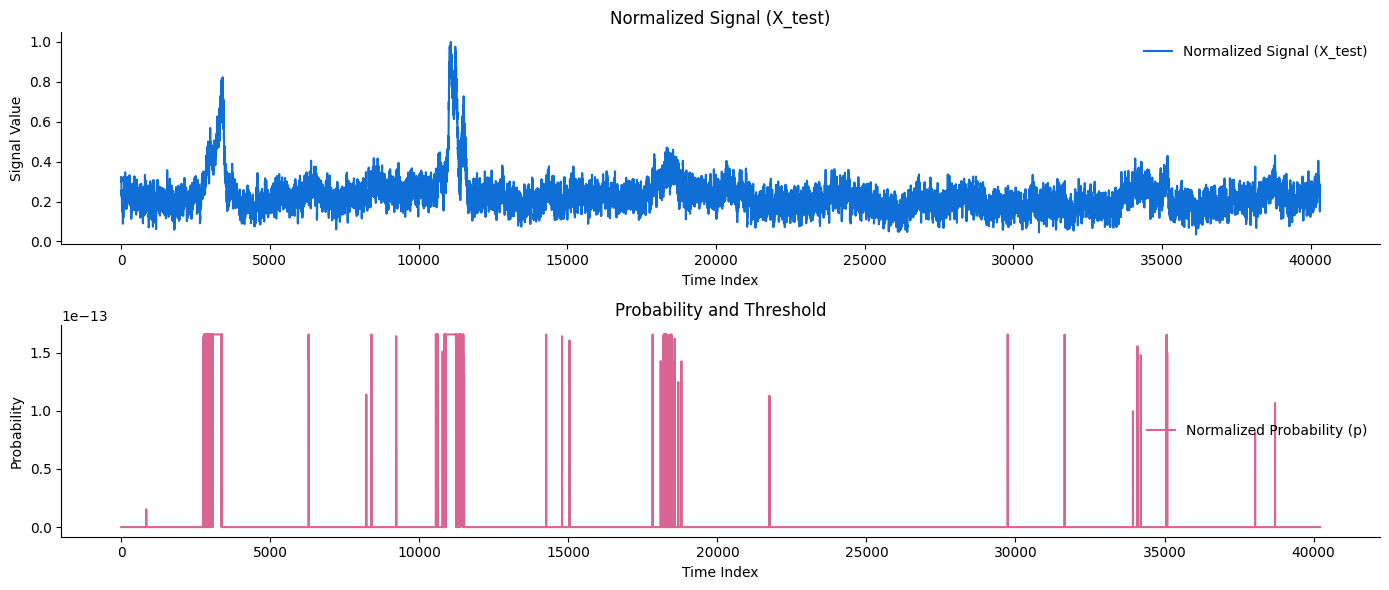

In [187]:
# Plot the X_test signal
plt.figure(figsize=(14, 6))


ax = plt.subplot(2, 1, 1)
plt.plot(X_test, label='Normalized Signal (X_test)', color='#0F6FD6')
plt.xlabel('Time Index')
plt.ylabel('Signal Value')
plt.title('Normalized Signal (X_test)')
plt.legend(frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Plot the probability p and the threshold
ax = plt.subplot(2, 1, 2)
plt.plot(p, label='Normalized Probability (p)', color='#DB6592')
plt.xlabel('Time Index')
plt.ylabel('Probability')
plt.title('Probability and Threshold')
plt.legend(frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


### Second thresholding method  :need to explore more the github 

In [195]:
def dynamic_thresholding(e_h, X_test, y_test, model):
    """
    Dynamic thresholding for anomaly detection.
    
    Args:
    e_h : historical errors (can be None in this case)
    X_test : test data (features)
    y_test : true labels for the test data
    model : trained model to make predictions
    
    Returns:
    e_s : normalized errors
    final_epsilon : the optimal epsilon threshold for anomaly detection
    """
    pred = model.predict(X_test)
    error = abs(pred - y_test)
    
    # Normalize the errors using softmax (to avoid extremely large values)
    e_s = np.exp(error) / np.sum(np.exp(error))

    e_s_mean = np.mean(e_s)
    e_s_std = np.std(e_s)
    
    max_score = -np.inf
    final_epsilon = 0.0
    
    # Search for the optimal epsilon
    for z in np.arange(2.0, 10.0, 0.5):
        epsilon = e_s_mean + z * e_s_std
        pruned_es = e_s[e_s < epsilon]

        anom_idx = np.argwhere(e_s >= epsilon).flatten()  # Flatten to get a 1D array of indices
        
        if len(anom_idx) > 0:
            # Group consecutive indices
            groups = [list(group) for group in consecutive_groups(anom_idx)]
            
            # Create sequences of start and end points for anomalies
            E_seq = [(g[0], g[-1]) for g in groups if not g[0] == g[-1]]

            # Calculate the score for the current epsilon
            delta_mean = e_s_mean - np.mean(pruned_es)
            delta_std = e_s_std - np.std(pruned_es)
            
            score = ((delta_mean / e_s_mean) + (delta_std / e_s_std)) \
                    / (len(E_seq) ** 2 + len(anom_idx))

            # Update if this score is better than the previous best score
            if score > max_score:
                max_score = score
                final_epsilon = epsilon

    print(final_epsilon)
    return e_s, final_epsilon

In [196]:
e_s, eps = dynamic_thresholding(None, x_test, y_test, model)
print(e_s)

1257/1257 ━━━━━━━━━━━━━━━━━━━━ 53s 42ms/step
4.8877874054536525e-05
[[2.63378538e-05]
 [2.67000338e-05]
 [2.55945336e-05]
 ...
 [2.35029489e-05]
 [2.43252940e-05]
 [2.50921574e-05]]


In [ ]:
class dynamic_thresholding():

    def _init_(self ,eh ,model ) -> None:
        
        self.eh =eh 
        self.model= model 
        

    def dynamic_thresholding(self, x, y, model):
        """

        Args:

        Return:

        """
        x = np.array(x).reshape(1, -1, 1)
        pred = model.predict(np.array(x).reshape(1, -1, 1))
        error = abs(pred - np.array(y).reshape(-1))

        es=self.eh+[error]

        #print(error)

        e_s = np.array(es)
        e_s = np.exp(e_s) / np.sum(np.exp(e_s))

        # e_s = np.concatenate((e_h, e_s))
        e_s_mean = np.mean(e_s)
        e_s_std = np.std(e_s)

        #print(e_s)
        max_score = -np.inf
        final_epsilon = 0.0

        for z in np.arange(2.0, 10.0, 0.5):
            epsilon = e_s_mean + z * e_s_std
            pruned_es = e_s[e_s < epsilon]

            #e_a = e_s[e_s > epsilon]
            anom_idx = np.argwhere(e_s >= epsilon).flatten()

            if len(anom_idx) > 0:
                print("qa")
                groups = [list(group) for group
                              in consecutive_groups(anom_idx)]
                E_seq = [(g[0], g[-1]) for g in groups if g[0] != g[-1]]

                delta_mean = e_s_mean - np.mean(pruned_es)
                delta_std = e_s_std - np.std(pruned_es)

                score = ((delta_mean / e_s_mean) + (delta_std / e_s_std)) \
                            / (len(E_seq) ** 2 + len(anom_idx))

                if score > max_score:
                    final_epsilon = epsilon

        self.eh.pop(0)

        anom_idx = np.argwhere(e_s >= final_epsilon).flatten()
        groups = [list(group) for group
                              in consecutive_groups(anom_idx)]
        E_seq = [(g[0], g[-1]) for g in groups if g[0] != g[-1]]


        if error > final_epsilon :

            return True , error- final_epsilon/(len(E_seq) ** 2 + len(anom_idx))

        else:
            return False  , 0
        

    def dynamic_thresholding_batch (self ,X_test ,Y_test ,model):

        predictions =[]
        probas=[]


        for x ,y in zip(X_test ,Y_test):
            print(x , y)
            prediction ,proba = self.dynamic_thresholding(x,y ,model)
            predictions.append(prediction)
            probas.append(proba)

        return np.array(predictions),np.array(probas)
    
class_dynamic = dynamic_thresholding(
    eh=abs(model.predict(X_test[:300]) - y_test[:300]), model = model
)

thresholding = class_dynamic.dynamic_thresholding_batch(X_test[300:], y_test[300:])

# Dynamic Thresholding: Needs tunning parameters

In [ ]:
import more_itertools as mit

class Errors:
    def __init__(self, model, X_test, y_test, l_s, window_size=30, batch_size=70):
        """
        Batch processing of errors between actual and predicted values
        for a channel.
        """
        self.l_s = l_s
        self.batch_size = batch_size
        self.window_size = window_size
        self.n_windows = int((y_test.shape[0] -
                              (batch_size * self.window_size))
                             / batch_size)
        self.i_anom = np.array([])
        self.E_seq = []
        self.anom_scores = []

        # raw prediction error
        self.e = abs(model.predict(X_test) - y_test)

        smoothing_window = int(batch_size * self.window_size * 0.05)
       
        # smoothed prediction error
        self.e_s = pd.DataFrame(self.e).ewm(span=smoothing_window)\
            .mean().values.flatten()

        # for values at beginning < sequence length, just use avg
        self.e_s[:self.l_s] = [np.mean(self.e_s[:self.l_s * 2])] * self.l_s


    def adjust_window_size(self, y_test):
        """
        Decrease the historical error window size (h) if number of test
        values is limited.
        """

        while self.n_windows < 0:
            self.window_size -= 1
            self.n_windows = int((y_test.shape[0]
                                 - (self.batch_size * self.window_size))
                                 / self.batch_size)
            if self.window_size == 1 and self.n_windows < 0:
                raise ValueError('Batch_size ({}) larger than y_test (len={}). '
                                 'Adjust in config.yaml.'
                                 .format(self.batch_size,
                                         y_test.shape[0]))

    def merge_scores(self):
        """
        If anomalous sequences from subsequent batches are adjacent they
        will automatically be combined. This combines the scores for these
        initial adjacent sequences (scores are calculated as each batch is
        processed) where applicable.
        """

        merged_scores = []
        score_end_indices = []

        for i, score in enumerate(self.anom_scores):
            if not score['start_idx']-1 in score_end_indices:
                merged_scores.append(score['score'])
                score_end_indices.append(score['end_idx'])

    def process_batches(self, y_test):
        """
        Top-level function for the Error class that loops through batches
        of values for a channel.

        Args:
            channel (obj): Channel class object containing train/test data
                for X,y for a single channel
        """

        self.adjust_window_size(y_test)

        for i in range(0, self.n_windows+1):
            prior_idx = i * self.batch_size
            idx = (self.window_size * self.batch_size) \
                  + (i * self.batch_size)
            if i == self.n_windows:
                idx = y_test.shape[0]

            window = ErrorWindow(y_test, self.batch_size, 
                                 self.l_s, 100, prior_idx, idx, self, i)

            window.find_epsilon()

            window.compare_to_epsilon(self)

            if len(window.i_anom) == 0:
                continue

            window.prune_anoms()

            if len(window.i_anom) == 0:
                continue

            window.i_anom = np.sort(np.unique(window.i_anom)).astype('int')
            window.score_anomalies(prior_idx)

            # update indices to reflect true indices in full set of values
            self.i_anom = np.append(self.i_anom, window.i_anom + prior_idx)
            self.anom_scores = self.anom_scores + window.anom_scores

        if len(self.i_anom) > 0:
            # group anomalous indices into continuous sequences
            groups = [list(group) for group in
                      mit.consecutive_groups(self.i_anom)]
            self.E_seq = [(int(g[0]), int(g[-1])) for g in groups
                          if not g[0] == g[-1]]

            # additional shift is applied to indices so that they represent the
            # position in the original data array, obtained from the .npy files,
            # and not the position on y_test (See PR #27).
            self.E_seq = [(e_seq[0] + self.l_s,
                           e_seq[1] + self.l_s) for e_seq in self.E_seq]

            self.merge_scores()


class ErrorWindow:
    def __init__(self, y_test, batch_size, l_s, 
                 error_buffer, start_idx, end_idx, errors, window_num):
        """
        Data and calculations for a specific window of prediction errors.
        Includes finding thresholds, pruning, and scoring anomalous sequences
        for errors.
        """
        self.batch_size = batch_size
        self.l_s = l_s
        self.i_anom = np.array([], dtype=int)
        self.E_seq = np.array([], dtype=int)
        self.non_anom_max = -1000000
        self.error_buffer = error_buffer
        self.anom_scores = []

        self.window_num = window_num

        self.e_s = errors.e_s[start_idx:end_idx]

        self.mean_e_s = np.mean(self.e_s)
        self.sd_e_s = np.std(self.e_s)

        self.epsilon = self.mean_e_s + 10. * self.sd_e_s

        self.y_test = y_test[start_idx:end_idx]
        self.sd_values = np.std(self.y_test)

        self.perc_high, self.perc_low = np.percentile(self.y_test, [95, 5])
        self.inter_range = self.perc_high - self.perc_low

        # ignore initial error values until enough history for processing
        self.num_to_ignore = self.l_s * 2
        # if y_test is small, ignore fewer
        if len(y_test) < 2500:
            self.num_to_ignore = self.l_s
        if len(y_test) < 1800:
            self.num_to_ignore = 0

    def find_epsilon(self):
        """
        Find the anomaly threshold that maximizes function representing
        tradeoff between:
            a) number of anomalies and anomalous ranges
            b) the reduction in mean and st dev if anomalous points are removed
            from errors
        """
        e_s = self.e_s

        max_score = -10000000

        for z in np.arange(2.0, 10.0, 0.5):
            epsilon = self.mean_e_s + (self.sd_e_s * z)

            pruned_e_s = e_s[e_s < epsilon]

            i_anom = np.argwhere(e_s >= epsilon).reshape(-1,)
            buffer = np.arange(1, self.error_buffer)
            i_anom = np.sort(np.concatenate((i_anom,
                                            np.array([i+buffer for i in i_anom])
                                             .flatten(),
                                            np.array([i-buffer for i in i_anom])
                                             .flatten())))
            i_anom = i_anom[(i_anom < len(e_s)) & (i_anom >= 0)]
            i_anom = np.sort(np.unique(i_anom))

            if len(i_anom) > 0:
                # group anomalous indices into continuous sequences
                groups = [list(group) for group
                          in mit.consecutive_groups(i_anom)]
                E_seq = [(g[0], g[-1]) for g in groups if not g[0] == g[-1]]

                mean_perc_decrease = (self.mean_e_s - np.mean(pruned_e_s)) \
                                     / self.mean_e_s
                sd_perc_decrease = (self.sd_e_s - np.std(pruned_e_s)) \
                                   / self.sd_e_s
                score = (mean_perc_decrease + sd_perc_decrease) \
                        / (len(E_seq) ** 2 + len(i_anom))

                # sanity checks / guardrails
                if score >= max_score and len(E_seq) <= 5 and \
                        len(i_anom) < (len(e_s) * 0.5):
                    max_score = score
                    self.sd_threshold = z
                    self.epsilon = self.mean_e_s + z * self.sd_e_s

    def compare_to_epsilon(self, errors_all):
        """
        Compare smoothed error values to epsilon (error threshold) and group
        consecutive errors together into sequences.
        """

        e_s = self.e_s 
        epsilon = self.epsilon

        # Check: scale of errors compared to values too small?
        if not (self.sd_e_s > (.05 * self.sd_values) or max(self.e_s)
                > (.05 * self.inter_range)) or not max(self.e_s) > 0.05:
            return

        i_anom = np.argwhere((e_s >= epsilon) &
                             (e_s > 0.05 * self.inter_range)).reshape(-1,)

        if len(i_anom) == 0:
            return
        buffer = np.arange(1, self.error_buffer+1)
        i_anom = np.sort(np.concatenate((i_anom,
                                         np.array([i + buffer for i in i_anom])
                                         .flatten(),
                                         np.array([i - buffer for i in i_anom])
                                         .flatten())))
        i_anom = i_anom[(i_anom < len(e_s)) & (i_anom >= 0)]

        # if it is first window, ignore initial errors (need some history)
        if self.window_num == 0:
            i_anom = i_anom[i_anom >= self.num_to_ignore]
        else:
            i_anom = i_anom[i_anom >= len(e_s) - self.batch_size]

        i_anom = np.sort(np.unique(i_anom))

        # capture max of non-anomalous values below the threshold
        # (used in filtering process)
        batch_position = self.window_num * self.batch_size
        window_indices = np.arange(0, len(e_s)) + batch_position
        adj_i_anom = i_anom + batch_position
        window_indices = np.setdiff1d(window_indices,
                                      np.append(errors_all.i_anom, adj_i_anom))
        candidate_indices = np.unique(window_indices - batch_position)
        non_anom_max = np.max(np.take(e_s, candidate_indices))

        # group anomalous indices into continuous sequences
        groups = [list(group) for group in mit.consecutive_groups(i_anom)]
        E_seq = [(g[0], g[-1]) for g in groups if not g[0] == g[-1]]

        self.i_anom = i_anom
        self.E_seq = E_seq
        self.non_anom_max = non_anom_max

    def prune_anoms(self):
        """
        Remove anomalies that don't meet minimum separation from the next
        closest anomaly or error value
        """
        self.p = 0.13
        E_seq = self.E_seq 
        e_s = self.e_s 
        non_anom_max = self.non_anom_max

        if len(E_seq) == 0:
            return

        E_seq_max = np.array([max(e_s[e[0]:e[1]+1]) for e in E_seq])
        E_seq_max_sorted = np.sort(E_seq_max)[::-1]
        E_seq_max_sorted = np.append(E_seq_max_sorted, [non_anom_max])

        i_to_remove = np.array([], dtype=int)
        for i in range(0, len(E_seq_max_sorted)-1):
            if (E_seq_max_sorted[i] - E_seq_max_sorted[i+1]) \
                    / E_seq_max_sorted[i] < self.p:
                i_to_remove = np.append(i_to_remove, np.argwhere(
                    E_seq_max == E_seq_max_sorted[i]))
            else:
                i_to_remove = np.array([])
        i_to_remove[::-1].sort()

        if len(i_to_remove) > 0:
            E_seq = np.delete(E_seq, i_to_remove, axis=0)

        elif len(E_seq) == 0:
            self.i_anom = np.array([], dtype=int)
            return

        indices_to_keep = np.array([], dtype=int)
        for e_seq in E_seq:
            indices_to_keep = np.concatenate((indices_to_keep, 
                                              np.array(range(e_seq[0], e_seq[-1]+1), dtype=int)))


        mask = np.isin(self.i_anom, indices_to_keep)
        self.i_anom = self.i_anom[mask]

    def score_anomalies(self, prior_idx):
        """
        Calculate anomaly scores based on max distance from epsilon
        for each anomalous sequence.
        """

        groups = [list(group) for group in mit.consecutive_groups(self.i_anom)]

        for e_seq in groups:

            score_dict = {
                "start_idx": e_seq[0] + prior_idx,
                "end_idx": e_seq[-1] + prior_idx,
                "score": 0
            }

            score = max([abs(self.e_s[i] - self.epsilon)
                         / (self.mean_e_s + self.sd_e_s) for i in
                         range(e_seq[0], e_seq[-1] + 1)])

            # the max score indicates whether anomaly was from regular
            # or inverted errors
            score_dict['score'] = score
            self.anom_scores.append(score_dict)

In [ ]:
dyn_thresholding = Errors(model, x_test, y_test, 100, window_size=30, batch_size=40)

In [ ]:
dyn_thresholding.process_batches(y_test)
print(dyn_thresholding.i_anom)